In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import random
import numpy as np
from skimage import transform
from collections import OrderedDict
import json
from pathlib import Path
from torchvision import transforms
from sklearn.model_selection import train_test_split
import skimage.transform as skTrans
import pandas as pd
import torch

with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)

In [2]:
def find_pix_dim(vol_img) :
    
    pix_dim = vol_img.header['pixdim']
    dim = vol_img.header['dim']
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY]

def preprocess_data(img, config, config_encoder, pixel_size, pixel_size_target, mask=None, data=0) :

    nx, ny = config_encoder["resize_size"]
    crop_size = config['crop_size']

    scale_vector = [pixel_size[0]/pixel_size_target[0], pixel_size[1]/pixel_size_target[1]]
    print('scale vector ', scale_vector)
    print('pixel_size ', pixel_size)
    print('pixel_size_target ', pixel_size_target)
    for slice_no in range(img.shape[2]) :
        slice_img = np.squeeze(img[:, :, slice_no])
        if mask is not None :
            slice_mask = np.squeeze(mask[:, :, slice_no])
            if data == 1 :
                slice_mask[slice_mask == 4] = 3
            if data == 2 :
                slice_mask[slice_mask != 0] = 1
        
        img_rescaled = transform.rescale(slice_img,
                                          scale_vector,
                                          order= 1,
                                          preserve_range = True,
                                          mode = 'constant')
        if mask is not None :
            mask_rescaled = transform.rescale(slice_mask,
                                              scale_vector,
                                              order= 0,
                                              preserve_range = True,
                                              mode = 'constant', 
                                              anti_aliasing = False)
        
        img_cropped = crop_or_pad_slice_to_size(img_rescaled, nx, ny )
        if mask is not None :
            mask_cropped = crop_or_pad_slice_to_size(mask_rescaled, nx, ny )
        
        #img_resized =  skTrans.resize(img_cropped, [nx, ny], order=1, preserve_range=True)
        #if mask is not None :
        #    mask_resized =  skTrans.resize(mask_cropped, [nx, ny], order=0, preserve_range=True, anti_aliasing = False)
        
        if(slice_no == 0) :
            imgs_cropped = np.reshape(img_cropped, (nx,ny,1))
            if mask is not None :
                masks_cropped = np.reshape(mask_cropped, (nx,ny,1))
        else :
            img_cropped_tmp = np.reshape(img_cropped, (nx,ny,1))
            imgs_cropped = np.concatenate((imgs_cropped, img_cropped_tmp), axis=2)
            if mask is not None :
                mask_cropped_tmp = np.reshape(mask_cropped, (nx,ny,1))
                masks_cropped = np.concatenate((masks_cropped, mask_cropped_tmp), axis=2)
    print('original ', slice_img.shape)
    print('rescale ',img_rescaled.shape)
    print('cropped ', img_cropped.shape)
        
    if mask is not None :
        return imgs_cropped, masks_cropped
    else: 
        return imgs_cropped

def normalize_minmax_data(image_data,min_val=1,max_val=99):
    """
    # 3D MRI scan is normalized to range between 0 and 1 using min-max normalization.
    Here, the minimum and maximum values are used as 1st and 99th percentiles respectively from the 3D MRI scan.
    We expect the outliers to be away from the range of [0,1].
    input params :
        image_data : 3D MRI scan to be normalized using min-max normalization
        min_val : minimum value percentile
        max_val : maximum value percentile
    returns:
        final_image_data : Normalized 3D MRI scan obtained via min-max normalization.
    """
    min_val_1p=np.percentile(image_data,min_val)
    max_val_99p=np.percentile(image_data,max_val)
    final_image_data=np.zeros((image_data.shape[0],image_data.shape[1],image_data.shape[2]), dtype=np.float64)
    # min-max norm on total 3D volume
    final_image_data=(image_data-min_val_1p)/(max_val_99p-min_val_1p)
    
    return final_image_data

def crop_or_pad_slice_to_size(img_slice, nx, ny):
    slice_cropped = np.zeros((nx,ny))
    x, y = img_slice.shape
    
    x_s = (x-nx) // 2
    y_s = (y-ny) // 2
    x_c = (nx-x) // 2
    y_c = (ny-y) // 2
    
    if x > nx and y > ny:
        slice_cropped = img_slice[x_s:x_s+nx, y_s:y_s+ny]
    else :
        slice_cropped = np.zeros((nx, ny))
        if x <= nx and y > ny :
            slice_cropped[x_c:x_c+x, :] = img_slice[:, y_s:y_s + ny]
        elif x > nx and y <= ny:
            slice_cropped[:, y_c:y_c + y] = img_slice[x_s:x_s + nx, :]
        else:
            slice_cropped[x_c:x_c + x, y_c:y_c + y] = img_slice[:, :]

    return slice_cropped

def visualize_data(data_dir1, data_dir2, data_dir3, data_dir4) :    
    
    data = nib.load(data_dir1)
    image_data1 = data.get_fdata()
    if len(image_data1.shape)== 4 :
        image_data1 = image_data1[:,:,:,0]
    
    data = nib.load(data_dir2)
    image_data2 = data.get_fdata()
    if len(image_data2.shape)== 4 :
        image_data2 = image_data2[:,:,:,0]
    print(len(np.unique(image_data2)))

    data = nib.load(data_dir3)
    image_data3 = data.get_fdata()
    if len(image_data3.shape)== 4 :
        image_data3 = image_data3[:,:,:,0]
    
    data = nib.load(data_dir4)
    image_data4 = data.get_fdata()
    if len(image_data4.shape)== 4 :
        image_data4 = image_data4[:,:,:,0]
    print(len(np.unique(image_data4)))

    fig, axs = plt.subplots(2, 2)
    idx1 = int(image_data1.shape[2]/2)
    axs[0, 0].imshow(image_data1[:,:,idx1], cmap = "gray")
    axs[0, 0].set_title(image_data1.shape)
    idx2 = int(image_data2.shape[2]/2)
    axs[0, 1].imshow(image_data2[:,:,idx2], cmap = "gray")
    axs[0, 1].set_title(image_data2.shape)
    idx3 = int(image_data3.shape[2]/2)
    axs[1, 0].imshow(image_data3[:,:,idx3], cmap = "gray")
    axs[1, 0].set_title(image_data3.shape)
    idx4 = int(image_data4.shape[2]/2)
    axs[1, 1].imshow(image_data4[:,:,idx4], cmap = "gray")
    axs[1, 1].set_title(image_data4.shape)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [3]:
def find_target_pixel_resolution(dataset, type_searching = 'mean') :
    
    pix_dims = []
    for path in Path(dataset['datadir']).rglob(dataset["subject_folder"]+dataset["name_img"]) :
        img_data = nib.load(path)
        img = img_data.get_fdata()
        pix_dims.append(find_pix_dim(img_data))        
        
    df = pd.DataFrame(pix_dims, columns = ['pix_dim_1', 'pix_dim_2'])
    df_diff = df.loc[df['pix_dim_1'] != df['pix_dim_2']]
    if len(df_diff) != 0 :
        print('different pixel resolution between axis')
        print('values removed : ', df_diff)
        df= df.drop(index=4)
    
    print('unique values found : ', np.unique(pix_dims))
    df['pix_dim_1'].hist()
    print('distribution of values: ', df['pix_dim_1'].value_counts())
    print('most frequent value : ', df['pix_dim_1'].mode())
    print('mean value : ', df['pix_dim_1'].mean())
    print('median value : ', df['pix_dim_1'].median())
        
        
    if type_searching == 'mean' :
        pixel_size_target = np.array(pix_dims).mean(axis = 0)
    elif type_searching == 'majority' :
        pixel_size_target = [df['pix_dim_1'].mode(), df['pix_dim_1'].mode()]

    else : 
        print('Error type of searching unknown')

    return pixel_size_target

CIMAS
unique values found :  [1.25]
distribution of values:  1.25    20
Name: pix_dim_1, dtype: int64
most frequent value :  0    1.25
dtype: float64
mean value :  1.25
median value :  1.25
MMWHS


KeyboardInterrupt: 

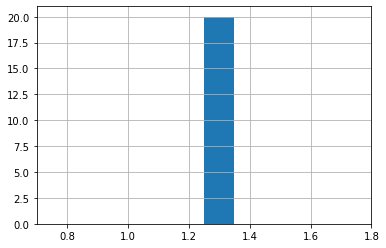

In [4]:
for dataset in config_datasets :
    #if dataset['experiment'] ==  "fine tuning":
    #if dataset['Data'] ==  "Metastases":
    print(dataset["Data"])
    #pixel_size_target = dataset['target_resolution']
    pix_dims = []
    pix_dims_mask = []

    X = []
    Y = []
    labels = []

    pix_dims = find_target_pixel_resolution(dataset, type_searching = 'majority')

empty_files = ['/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/10/img.nii.gz',
              '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/14/img.nii.gz',
              '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/19/img.nii.gz',
              '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/02/5/img.nii.gz']

In [5]:
with open('configs/config_encoder.json') as config_file:
    config_encoder = json.load(config_file)
count = 0
for dataset in config_datasets :
    
    #if dataset['experiment'] ==  "pretraining" or dataset['experiment'] ==  "fine tuning" :
    
    if dataset['Data'] == "Metastases":
        
    #if dataset['Data'] != 'ACDC' and dataset['Data'] != 'Medical Decathelon Lung' :
        if dataset['Data'] == 'Chaos':
            no_mask = True
        else : 
            no_mask = False

        
        X = []
        if no_mask == False:
            Y = []
        labels = []
        
        print(dataset['Data'])
        pixel_size_target = dataset['target_resolution']
        print('TARGET : ', pixel_size_target )
        
        for path in Path(dataset['datadir']).rglob(dataset["subject_folder"]) :
            print(path)
            
            if '.nii.gz' in str(path) or '.png' in str(path) or 'script.sh' in str(path) or '.npz' in str(path):
                continue
            if '/chaos/ct/02/5' in str(path):
                print('pass')
                continue
            

            for path_image in path.rglob(dataset["name_img"]) :
                if path_image == '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/02/5':
                    continue
                img_data = nib.load(path_image)
                pixel_size = img_data.header['pixdim'][1:4]
                affine_img = img_data.affine
                img = img_data.get_fdata()
            
            if no_mask == False:
                for path_mask in path.rglob(dataset["name_mask"]) :
                    mask_data = nib.load(path_mask)
                    affine_mask = mask_data.affine
                    mask = mask_data.get_fdata()
                    
                assert(mask.shape[0:3] == img.shape[0:3])
            
            if no_mask == False:
                if dataset["Data"] == "CIMAS" :
                    img_cropped, mask_cropped = preprocess_data(img[:,:,:,0], dataset, config_encoder, pixel_size, pixel_size_target, mask[:,:,:,0], 1)
                elif dataset["Data"] == "Medical Decathelon Prostate" :
                    img_cropped, mask_cropped = preprocess_data(img[:,:,:,0], dataset, config_encoder, pixel_size, pixel_size_target, mask,1)
                elif dataset["Data"] == "Metastases" :
                    img_cropped, mask_cropped = preprocess_data(img, dataset, config_encoder, pixel_size, pixel_size_target, mask,2)
                else :
                    img_cropped, mask_cropped = preprocess_data(img, dataset, config_encoder, pixel_size, pixel_size_target, mask, 0)
            else :
                img_cropped = preprocess_data(img, dataset, config_encoder, pixel_size, pixel_size_target, mask = None, data=0)
            img_normalized=normalize_minmax_data(img_cropped)
            img_normalized=np.clip(img_normalized, 0,1.5)

            array_img = nib.Nifti1Image(img_normalized, affine_img)
            if no_mask == False:
                array_mask = nib.Nifti1Image(np.round(mask_cropped, decimals = 0), affine_mask)
            
            X.append(array_img)
            if no_mask == False:
                Y.append(array_mask)
            if dataset['Data'] == 'Metastases' :
                labels.append(int(str(path)[-dataset['n_char_subj']:].replace('-', '')))
            else:
                labels.append(int(str(path)[-dataset['n_char_subj']:]))
                
            #if count > 2 : 
            #    break
            count += 1
        if dataset['experiment'] ==  "fine tuning" :
            test_ratio = 0.3
        else :
            test_ratio = 0.25
        #Split train validation test
        if no_mask == False:
            X_tr, X_te, Y_tr, Y_te, labels_tr, labels_te = train_test_split(X, Y,labels, test_size=test_ratio, random_state=1)
        else : 
            X_tr, X_te, labels_tr, labels_te = train_test_split(X, labels, test_size=test_ratio, random_state=1)
            
        for i in range(len(X_tr)):
            save_dir = dataset["savedir"] + 'train/subject_' +  str(labels_tr[i]) 
            Path(save_dir).mkdir(parents = True, exist_ok = True)
            img_filename = str(save_dir)+'/img.nii.gz'
            nib.save(X_tr[i], img_filename)
            if no_mask == False:
                mask_filename = str(save_dir)+'/mask.nii.gz'
                nib.save(Y_tr[i], mask_filename)
            
        for i in range(len(X_te)):
            save_dir = dataset["savedir"] + 'test/subject_' +  str(labels_te[i]) 
            Path(save_dir).mkdir(parents = True, exist_ok = True)
            img_filename = str(save_dir)+'/img.nii.gz'
            nib.save(X_te[i], img_filename)
            if no_mask == False:
                mask_filename = str(save_dir)+'/mask.nii.gz'
                nib.save(Y_te[i], mask_filename)

            

        

Metastases
TARGET :  [1.0, 1.0]
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000046-57
scale vector  [0.46880000829696655, 0.46880000829696655]
pixel_size  [0.4688    0.4688    0.6996408]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (164, 164)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000018-26
scale vector  [0.6000000238418579, 0.6000000238418579]
pixel_size  [0.6 0.6 0.6]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (210, 210)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000075-9
scale vector  [0.6000000238418579, 0.6000000238418579]
pixel_size  [0.6 0.6 0.6]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (210, 210)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatas

scale vector  [0.6000000238418579, 0.6000000238418579]
pixel_size  [0.6 0.6 0.6]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (210, 210)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000028-36
scale vector  [0.48828125, 0.48828125]
pixel_size  [0.48828125 0.48828125 0.90000004]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (171, 171)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000002-115
scale vector  [0.5555555820465088, 0.5555555820465088]
pixel_size  [0.5555556 0.5555556 0.6      ]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (194, 194)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000072-84
scale vector  [0.6818181872367859, 0.6818181872367859]
pixel_siz

scale vector  [0.48828125, 0.48828125]
pixel_size  [0.48828125 0.48828125 1.        ]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (171, 171)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000021-3
scale vector  [0.6000000238418579, 0.6000000238418579]
pixel_size  [0.6 0.6 0.6]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (210, 210)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000058-71
scale vector  [0.42969998717308044, 0.42969998717308044]
pixel_size  [0.4297   0.4297   0.699314]
pixel_size_target  [1.0, 1.0]
original  (350, 350)
rescale  (150, 150)
cropped  (192, 192)
/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/000025-33
scale vector  [0.6000000238418579, 0.6000000238418579]
pixel_size  

original  (350, 350)
rescale  (210, 210)
cropped  (192, 192)


ValueError: invalid literal for int() with base 10: 'i.xfm'

In [6]:
X = X[0:77]
Y = Y[0:77]

if dataset['experiment'] ==  "fine tuning" :
    test_ratio = 0.3
else :
    test_ratio = 0.25
#Split train validation test
if no_mask == False:
    X_tr, X_te, Y_tr, Y_te, labels_tr, labels_te = train_test_split(X, Y,labels, test_size=test_ratio, random_state=1)
else : 
    X_tr, X_te, labels_tr, labels_te = train_test_split(X, labels, test_size=test_ratio, random_state=1)

for i in range(len(X_tr)):
    save_dir = dataset["savedir"] + 'train/subject_' +  str(labels_tr[i]) 
    Path(save_dir).mkdir(parents = True, exist_ok = True)
    img_filename = str(save_dir)+'/img.nii.gz'
    nib.save(X_tr[i], img_filename)
    if no_mask == False:
        mask_filename = str(save_dir)+'/mask.nii.gz'
        nib.save(Y_tr[i], mask_filename)

for i in range(len(X_te)):
    save_dir = dataset["savedir"] + 'test/subject_' +  str(labels_te[i]) 
    Path(save_dir).mkdir(parents = True, exist_ok = True)
    img_filename = str(save_dir)+'/img.nii.gz'
    nib.save(X_te[i], img_filename)
    if no_mask == False:
        mask_filename = str(save_dir)+'/mask.nii.gz'
        nib.save(Y_te[i], mask_filename)

## CIMAS

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/cimas_cardiac/mr/' 
data_dir1 = path_dataset + '03/img.nii.gz'
data_dir2 = path_dataset + '03/seg.nii.gz'
data_dir3 = path_dataset + '05/img.nii.gz'
data_dir4 = path_dataset + '05/seg.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/cimas/' 
data_dir1 = path_dataset + 'train/subject_3/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_3/mask.nii.gz'
data_dir3 = path_dataset + 'train/subject_5/img.nii.gz'
data_dir4 = path_dataset + 'train/subject_5/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## ACDC

In [ ]:
# Before
path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr_original/' 
data_dir1 = path_dataset + 'patient001/patient001_frame01.nii.gz'
data_dir2 = path_dataset + 'patient001/patient001_frame01_gt.nii.gz'
data_dir3 = path_dataset + 'patient002/patient002_frame01.nii.gz'
data_dir4 = path_dataset + 'patient002/patient002_frame01_gt.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/acdc/' 
data_dir1 = path_dataset + 'train/subject_1/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_1/mask.nii.gz'
data_dir3 = path_dataset + 'train/subject_8/img.nii.gz'
data_dir4 = path_dataset + 'train/subject_8/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## Abide

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/abide/caltech/t1w/orig/' 
data_dir1 = path_dataset + 'A00033261/img.nii.gz'
data_dir2 = path_dataset + 'A00033261/seg.nii.gz'
data_dir3 = path_dataset + 'A00033263/img.nii.gz'
data_dir4 = path_dataset + 'A00033263/seg.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/abide/' 
data_dir1 = path_dataset + 'train/subject_33261/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_33261/mask.nii.gz'
data_dir3 = path_dataset + 'train/subject_33285/img.nii.gz'
data_dir4 = path_dataset + 'train/subject_33285/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## Chaos

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/' 
data_dir1 = path_dataset + '02/img.nii.gz'
data_dir2 = path_dataset + '05/img.nii.gz'
data_dir3 = path_dataset + '06/img.nii.gz'
data_dir4 = path_dataset + '16/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/chaos/' 
data_dir1 = path_dataset + 'train/subject_2/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_5/img.nii.gz'
data_dir3 = path_dataset + 'train/subject_6/img.nii.gz'
data_dir4 = path_dataset + 'train/subject_16/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## HCP

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/HCP_brain_3T/' 
data_dir1 = path_dataset + '103414/T1w_acpc_dc_restore_brain_onMNI.nii.gz'
data_dir2 = path_dataset + '103414/T1w_acpc_dc_restore_labels_onMNI.nii.gz'
data_dir3 = path_dataset + '105115/T1w_acpc_dc_restore_brain_onMNI.nii.gz'
data_dir4 = path_dataset + '105115/T1w_acpc_dc_restore_labels_onMNI.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/HCP/' 
data_dir1 = path_dataset + 'train/subject_103414/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_103414/mask.nii.gz'
data_dir3 = path_dataset + 'train/subject_105115/img.nii.gz'
data_dir4 = path_dataset + 'train/subject_105115/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## Medical Decathelon Prostate

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/prostate_md/' 
data_dir1 = path_dataset + '004/img.nii.gz'
data_dir2 = path_dataset + '004/mask.nii.gz'
data_dir3 = path_dataset + '010/img.nii.gz'
data_dir4 = path_dataset + '010/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/medDecatProstate/' 
data_dir1 = path_dataset + 'train/subject_4/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_4/mask.nii.gz'
data_dir3 = path_dataset + 'train/subject_10/img.nii.gz'
data_dir4 = path_dataset + 'train/subject_10/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## MMWHS

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/MMWHS/MR/train/' 
data_dir1 = path_dataset + '1001/img.nii.gz'
data_dir2 = path_dataset + '1001/seg.nii.gz'
data_dir3 = path_dataset + '1010/img.nii.gz'
data_dir4 = path_dataset + '1010/seg.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/MMWHS/MR/train/' 
data_dir1 = path_dataset + '1003/img.nii.gz'
data_dir2 = path_dataset + '1003/seg.nii.gz'
data_dir3 = path_dataset + '1004/img.nii.gz'
data_dir4 = path_dataset + '1004/seg.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/MMWHS/' 
data_dir1 = path_dataset + 'test/subject_1013/img.nii.gz'
data_dir2 = path_dataset + 'test/subject_1013/mask.nii.gz'
data_dir3 = path_dataset + 'test/subject_1016/img.nii.gz'
data_dir4 = path_dataset + 'test/subject_1016/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

# Metastases

In [ ]:
# Before

path_dataset = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ/metastases_segmentation/Processed/Processed/Melanoma_nii/' 
data_dir1 = path_dataset + '000000-1/vol.nii.gz'
data_dir2 = path_dataset + '000000-1/seg_mask.nii.gz'
data_dir3 = path_dataset + '000001-10/vol.nii.gz'
data_dir4 = path_dataset + '000001-10/seg_mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [ ]:
# After

path_dataset = '../img_cropped/metastases/' 
data_dir1 = path_dataset + 'train/subject_3745/img.nii.gz'
data_dir2 = path_dataset + 'train/subject_3745/mask.nii.gz'
data_dir3 = path_dataset + 'train/subject_486/img.nii.gz'
data_dir4 = path_dataset + 'train/subject_486/mask.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)